<a href="https://colab.research.google.com/github/seismosmsr/machine_learning/blob/main/LandCover_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')


In [2]:
# !pip install rasterio scikit-image tensorflow keras gdown


In [60]:
import os
import gdown
import zipfile
import rasterio
from skimage.transform import resize
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random
from keras.utils import to_categorical
from skimage.util import random_noise

In [4]:
# # Download the dataset
# url = 'https://drive.google.com/uc?id=1f4eGmykyiczmNz2VPeNNmQ7aC7q8N_hD'
# output = '/content/california_land_use.zip'
# gdown.download(url, output, quiet=False)

# # Extract the dataset
# cwd = os.getcwd()
# with zipfile.ZipFile(output, 'r') as zip_ref:
#     zip_ref.extractall(cwd+'/sample_data')


In [5]:
# Required libraries
import rasterio
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import os
import glob

In [6]:
# Loading data from geotiff files
def load_data(directory):
    data = []
    files = glob.glob(os.path.join(directory, "*.tif"))
    for file in files:
        with rasterio.open(file) as src:
            band_data = []
            for band in src.read():
                band_data.append(band)
            data.append(np.dstack(band_data))
    
    return np.array(data)

In [24]:
def load_and_reshape_image(image_path, img_height, img_width):
    with rasterio.open(image_path) as src:
        # Read the image data
        image = src.read()
        # Reshape the image
        image = image.transpose((1, 2, 0))
        # Resize image if necessary
        if image.shape[0] != img_height or image.shape[1] != img_width:
            image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
        # Ensure labels do not have an extra channel dimension
        if len(image.shape) == 3 and image.shape[2] == 1:
            image = np.squeeze(image, axis=2)
        return image

In [8]:
def load_images_and_labels(image_files, label_files, img_height, img_width, num_classes):
  images = []
  labels = []

  image_files = glob.glob(os.path.join(image_files, "*.tif"))
  for image_file in image_files:
      image = load_and_reshape_image(image_file, img_height, img_width)
      images.append(image)

  label_files = glob.glob(os.path.join(label_files, "*.tif"))
  for label_file in label_files:
      label = load_and_reshape_image(label_file, img_height, img_width)
      label -= 1  # adjust labels to be in the range 0-8 instead of 1-9
      label = to_categorical(label, num_classes=9)   # one-hot encode the labels
      labels.append(label)

  return np.array(images), np.array(labels)



In [74]:
import glob
import os
import cv2
import numpy as np
import rasterio
from keras.utils import Sequence, to_categorical

class DataGenerator(Sequence):
    def __init__(self, image_folder, label_folder, img_height, img_width, batch_size, num_classes, noise):
        self.image_files = glob.glob(os.path.join(image_folder, "*.tif"))
        self.label_files = glob.glob(os.path.join(label_folder, "*.tif"))
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.noise = noise

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        batch_images, batch_labels = self.load_images_and_labels(batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read()
            image = image.transpose((1, 2, 0))
            if image.shape[0] != self.img_height or image.shape[1] != self.img_width:
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
            if len(image.shape) == 3 and image.shape[2] == 1:
                image = np.squeeze(image, axis=2)
            if self.noise:
                variance = np.var(image)
                image = image*random_noise(image, mode='gaussian', var=variance)
            return image

    def load_images_and_labels(self, image_files):
        images = []
        labels = []

        for image_file in image_files:
            image = self.load_and_reshape_image(image_file)
            images.append(image)

        for image_file in image_files:
            label_file = image_file.replace("rgbNIR", "labels")
            label = self.load_and_reshape_image(label_file)
            label -= 1
            label = to_categorical(label, num_classes=self.num_classes)
            labels.append(label)

        return np.array(images), np.array(labels)


In [16]:
train_files = glob.glob('/content/sample_data/training/rgbNIR/*.tif')
validation_files = glob.glob('/content/sample_data/validation/rgbNIR/*.tif')

train_partition = {os.path.splitext(os.path.basename(f))[0]: f for f in train_files}
validation_partition = {os.path.splitext(os.path.basename(f))[0]: f for f in validation_files}

train_labels = {os.path.splitext(os.path.basename(f))[0]: f.replace('rgbNIR', 'labels') for f in train_files}
validation_labels = {os.path.splitext(os.path.basename(f))[0]: f.replace('rgbNIR', 'labels') for f in validation_files}

training_generator = DataGenerator(train_partition, train_labels)
validation_generator = DataGenerator(validation_partition, validation_labels)

# model.fit(training_generator, validation_data=validation_generator, epochs=100)


In [9]:
X_train, y_train = load_images_and_labels('/content/sample_data/training/rgbNIR/', '/content/sample_data/training/labels/', 640, 640,num_classes =9)

X_test, y_test = load_images_and_labels('/content/sample_data/validation/rgbNIR/', '/content/sample_data/validation/labels/', 640, 640,num_classes =9)

# Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def create_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size)  # Change the number of channels to 4

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])  # Use sparse categorical cross-entropy loss
    return model


In [18]:
model = create_model(img_size = (640,640,3),num_classes =9)

In [78]:
training_image_folder = "/content/sample_data/training/rgbNIR"  # Replace with your image folder path
training_label_folder = "/content/sample_data/training/labels"  # Replace with your label folder path

validation_image_folder = "/content/sample_data/validation/rgbNIR"  # Replace with your image folder path
validation_label_folder = "/content/sample_data/validation/labels"  # Replace with your label folder path


img_height = 640  # Set your desired image height
img_width = 640  # Set your desired image width
batch_size = 16  # Set your desired batch size
num_classes = 9  # Set the number of classes for one-hot encoding

# Create the data generator
training_data_generator = DataGenerator(training_image_folder, training_label_folder, img_height, img_width, batch_size, num_classes,True)
validation_data_generator = DataGenerator(validation_image_folder, validation_label_folder, img_height, img_width, batch_size, num_classes,False)


In [79]:
# Train the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=50)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(training_data_generator, validation_data=validation_data_generator, epochs=20)

# Evaluate the model
loss, accuracy = model.evaluate(validation_data_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# model.fit(training_generator, validation_data=validation_generator, epochs=100)

Epoch 1/20
87/87 [==============================] - 194s 2s/step - loss: 0.8047 - accuracy: 0.7015 - val_loss: 1.3188 - val_accuracy: 0.5774
Epoch 2/20
87/87 [==============================] - 191s 2s/step - loss: 0.7388 - accuracy: 0.7249 - val_loss: 1.4171 - val_accuracy: 0.5645
Epoch 3/20
87/87 [==============================] - 191s 2s/step - loss: 0.6842 - accuracy: 0.7439 - val_loss: 1.3326 - val_accuracy: 0.5811
Epoch 4/20
87/87 [==============================] - 190s 2s/step - loss: 0.6322 - accuracy: 0.7623 - val_loss: 1.3400 - val_accuracy: 0.5898
Epoch 5/20
87/87 [==============================] - 193s 2s/step - loss: 0.6022 - accuracy: 0.7733 - val_loss: 1.3861 - val_accuracy: 0.6007
Epoch 6/20
87/87 [==============================] - 192s 2s/step - loss: 0.5776 - accuracy: 0.7819 - val_loss: 1.3129 - val_accuracy: 0.6020
Epoch 7/20
87/87 [==============================] - 193s 2s/step - loss: 0.5520 - accuracy: 0.7908 - val_loss: 1.4284 - val_accuracy: 0.6102
Epoch 8/20
87

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 59ms/step


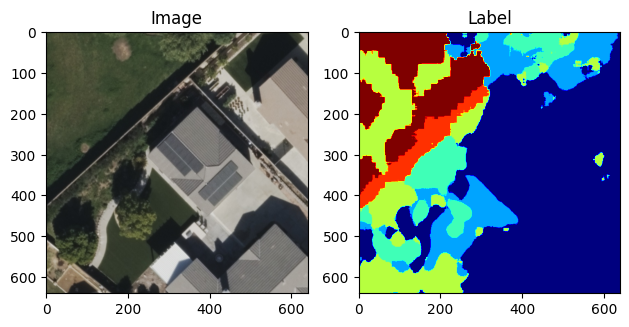

In [80]:
import matplotlib.pyplot as plt

# Get a batch of data from the generator
batch_images, batch_labels = validation_data_generator[3]

# Run predictions on the sample
predictions = model.predict(batch_images)

# Select a random index from the batch
index = np.random.randint(0, batch_images.shape[0])

# Retrieve the image and label at the selected index
image = batch_images[index]
label = predictions[index]

# Rescale the image to the range [0, 1]
image = image.astype(np.float32) / 255.0

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image")

# Plot the label
plt.subplot(1, 2, 2)
plt.imshow(np.argmax(label, axis=-1), cmap='jet')
plt.title("Label")

plt.tight_layout()
plt.show()


In [37]:
# Assuming you have already defined and compiled the model

# Get a single sample of validation data
sample_X, sample_y = next(validation_generator)

# Run predictions on the sample
predictions = model.predict(sample_X)

# Plot the sample image with its corresponding label and predicted label
plot_image_with_predictions(sample_X[0], sample_y[0], predictions[0])


TypeError: ignored